### setup

In [1]:
from FireSimulator import *
from FireSimulatorUtilities import *

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

### set up initial conditon

In [21]:
alpha = 0.2
beta = np.exp(-1/10)
gamma = 0.95
grid_size = 50
dp = 0.54
capacity = 4

In [ ]:
x = math.ceil(grid_size/2)
fire_init = []
fire_init.append((x,x))
for d in range(1,3):
    fire_init.append((x-d,x+d))
    fire_init.append((x+d,x+d))
    fire_init.append((x-d,x-d))
    fire_init.append((x+d,x-d))

sim = FireSimulator(grid_size, fire_init=fire_init)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plt.xlim([0,grid_size+1])
plt.ylim([0,grid_size+1])
plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)

for i in range(grid_size):
    for j in range(grid_size):
        x = col_to_x(j)
        y = row_to_y(grid_size,i)
        
        #if sim.state[i,j] == 0:
        #    rect = patches.Rectangle((x-0.5,y-0.5), 1, 1, alpha=0.6, color='g')
        #    ax.add_patch(rect)
        if sim.state[i,j] == 1:
            rect = patches.Rectangle((x-0.5,y-0.5), 1, 1, alpha=0.6, color='r')
            ax.add_patch(rect)

### benchmark vw policy

In [22]:
def vw(sim, alpha, dbeta, gamma, weights, capacity):
    control = []
    fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]
    if not sim.fires:
        return control
    
    for f in sim.fires:
        ni = 0
        x,y = f
        rf = y_to_row(grid_size,y)
        cf = x_to_col(x)
        for (dr,dc) in fire_neigh:
            rn = rf + dr
            cn = cf + dc
            
            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn]==0:
                counter = 0
                for (dr2,dc2) in fire_neigh:
                    rm = rn + dr2
                    cm = rn + dc2
                    
                    if rm>=0 and rm<grid_size and cm>=0 and cm<grid_size and sim.state[rm,cm]==1:
                        counter += 1
                        
                ni += (1 - alpha*counter)
        
        #value = (alpha - gamma*weights[2])*dbeta*ni
        value = dbeta - gamma*weights[2]*dbeta*ni
        control.append((value,f))
        
    control = sorted(control, key=lambda tup: tup[0], reverse=True)
    control = control[:capacity]
    control = [el[1] for el in control]   
    
    return control

In [23]:
h_vw = []
weights_vw = [9.38271605, 1.2345679, -0.03367766]

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()

for s in range(1000):
    sim = FireSimulator(grid_size, rng=s)
    #sim = FireSimulator(grid_size, rng=s, fire_init=fire_init)
    
    while not sim.end:
        action = []
        action = vw(sim, alpha, dp, gamma, weights_vw, capacity)
        
        sim.step(action, dbeta=dp)
        #print(sim.fires)
        #print(action)
        #break
        
    h_vw.append(sim.stats[0]/np.sum(sim.stats))
    if (s+1) % 100 == 0:
        st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        print('[%s] completed %d simulations' %(st,s+1))
    
st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-18 16:24:23] start
[2018-03-18 16:24:25] completed 100 simulations
[2018-03-18 16:24:26] completed 200 simulations
[2018-03-18 16:24:27] completed 300 simulations
[2018-03-18 16:24:28] completed 400 simulations
[2018-03-18 16:24:29] completed 500 simulations
[2018-03-18 16:24:30] completed 600 simulations
[2018-03-18 16:24:31] completed 700 simulations
[2018-03-18 16:24:32] completed 800 simulations
[2018-03-18 16:24:33] completed 900 simulations
[2018-03-18 16:24:34] completed 1000 simulations
[2018-03-18 16:24:34] finish
11.56s = 0.19m elapsed


min: 0.12
mean: 0.98
median: 0.98
max: 0.99


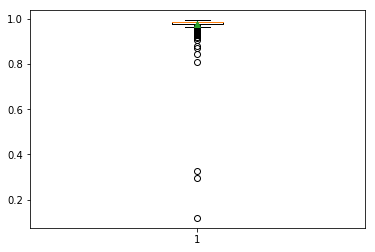

In [24]:
plt.boxplot(h_vw, showmeans=True)

print('min: %0.2f' %np.amin(h_vw))
print('mean: %0.2f' % np.mean(h_vw))
print('median: %0.2f' %np.median(h_vw))
print('max: %0.2f' %np.amax(h_vw))

### benchmark Qw method

In [9]:
def Qw(sim, alpha, dbeta, gamma, weights, capacity):
    control = []
    fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]
    if not sim.fires:
        return control
    
    for f in sim.fires:
        ni = 0
        x,y = f
        rf = y_to_row(grid_size,y)
        cf = x_to_col(x)
        for (dr,dc) in fire_neigh:
            rn = rf + dr
            cn = cf + dc
            
            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn]==0:
                counter = 0
                for (dr2,dc2) in fire_neigh:
                    rm = rn + dr2
                    cm = rn + dc2
                    
                    if rm>=0 and rm<grid_size and cm>=0 and cm<grid_size and sim.state[rm,cm]==1:
                        counter += 1
                        
                ni += (1 - alpha*counter)
        
        value = weights[3]*ni
        control.append((value,f))
        
    print(control)
    control = sorted(control, key=lambda tup: tup[0], reverse=True)
    print(control)
    control = control[:capacity]
    control = [el[1] for el in control]   
    
    5/0
    
    return control

In [10]:
h_Qw = []
weights_Qw = [9.87, 0.243, 0, -0.18]

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()

for s in range(1000):
    sim = FireSimulator(grid_size, rng=s)
    #sim = FireSimulator(grid_size, rng=s, fire_init=fire_init)
    
    while not sim.end:
        action = []
        action = Qw(sim, alpha, dp, gamma, weights_Qw, capacity)
        
        sim.step(action, dbeta=dp)
        #print(sim.fires)
        #print(action)
       
    h_Qw.append(sim.stats[0]/np.sum(sim.stats))
    if (s+1) % 100 == 0:
        st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        print('[%s] completed %d simulations' %(st,s+1))
    
st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-18 14:57:21] start
[(-0.288, (24, 24)), (-0.03599999999999999, (24, 25)), (-0.03599999999999999, (24, 26)), (-0.288, (24, 27)), (-0.18, (25, 24)), (-0.0, (25, 25)), (-0.0, (25, 26)), (-0.18, (25, 27)), (-0.18, (26, 24)), (-0.0, (26, 25)), (-0.0, (26, 26)), (-0.18, (26, 27)), (-0.288, (27, 24)), (-0.03599999999999999, (27, 25)), (-0.03599999999999999, (27, 26)), (-0.288, (27, 27))]
[(-0.0, (25, 25)), (-0.0, (25, 26)), (-0.0, (26, 25)), (-0.0, (26, 26)), (-0.03599999999999999, (24, 25)), (-0.03599999999999999, (24, 26)), (-0.03599999999999999, (27, 25)), (-0.03599999999999999, (27, 26)), (-0.18, (25, 24)), (-0.18, (25, 27)), (-0.18, (26, 24)), (-0.18, (26, 27)), (-0.288, (24, 24)), (-0.288, (24, 27)), (-0.288, (27, 24)), (-0.288, (27, 27))]


ZeroDivisionError: division by zero

In [ ]:
plt.boxplot(h_Qw, showmeans=True)

print('min: %0.2f' %np.amin(h_Qw))
print('mean: %0.2f' % np.mean(h_Qw))
print('median: %0.2f' %np.median(h_Qw))
print('max: %0.2f' %np.amax(h_Qw))

### benchmark Forsell et al. basis functions

In [25]:
def prior(sim, alpha, dbeta, gamma, weights, capacity):
    control = []
    fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]
    if not sim.fires:
        return control
    
    for f in sim.fires:
        ni = 0
        x,y = f
        rf = y_to_row(grid_size,y)
        cf = x_to_col(x)
        for (dr,dc) in fire_neigh:
            rn = rf + dr
            cn = cf + dc
            
            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn]==0:
                counter = 0
                for (dr2,dc2) in fire_neigh:
                    rm = rn + dr2
                    cm = rn + dc2
                    
                    if rm>=0 and rm<grid_size and cm>=0 and cm<grid_size and sim.state[rm,cm]==1:
                        counter += 1
                        
                ni += (1 - alpha*counter)
        
        #value = alpha*dbeta*ni - gamma*weights[1]*dbeta + gamma*weights[2]*dbeta
        value = dbeta - gamma*weights[1]*dbeta + gamma*weights[2]*dbeta
        control.append((value,f))
        
    control = sorted(control, key=lambda tup: tup[0], reverse=True)[:capacity]
    control = [el[1] for el in control]   
    
    return control

In [26]:
h_prior = []
# weights_prior = [1.22701395, -0.03731834, 0.02621872]
weights_prior = [-1.02949270, -1.07226902, 4.75769649e-10]

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' % st)

tic = time.clock()

for s in range(1000):
    sim = FireSimulator(grid_size, rng=s)
    #sim = FireSimulator(grid_size, rng=s, fire_init=fire_init)
    
    while not sim.end:
        action = []
        action = prior(sim, alpha, dp, gamma, weights_prior, capacity)
        
        sim.step(action, dbeta=dp)
        #print(sim.fires)
        #print(action)
       
    h_prior.append(sim.stats[0]/np.sum(sim.stats))
    if (s+1) % 100 == 0:
        st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        print('[%s] completed %d simulations' %(st,s+1))
    
st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' % st)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

[2018-03-18 16:43:22] start
[2018-03-18 16:44:41] completed 100 simulations
[2018-03-18 16:46:02] completed 200 simulations
[2018-03-18 16:47:16] completed 300 simulations
[2018-03-18 16:48:31] completed 400 simulations
[2018-03-18 16:49:48] completed 500 simulations
[2018-03-18 16:50:58] completed 600 simulations
[2018-03-18 16:52:16] completed 700 simulations
[2018-03-18 16:53:28] completed 800 simulations
[2018-03-18 16:54:50] completed 900 simulations
[2018-03-18 16:56:09] completed 1000 simulations
[2018-03-18 16:56:09] finish
763.61s = 12.73m elapsed


min: 0.00
mean: 0.15
median: 0.01
max: 0.99


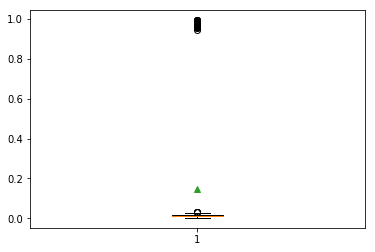

In [27]:
plt.boxplot(h_prior, showmeans=True)

print('min: %0.2f' %np.amin(h_prior))
print('mean: %0.2f' % np.mean(h_prior))
print('median: %0.2f' %np.median(h_prior))
print('max: %0.2f' %np.amax(h_prior))